In [1]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
import matplotlib.pyplot as plt

/Users/amitej/amitejmehta/fine-tuning/fine-tuning-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


*This cell is only necessary if using python environments with jupyter notebooks. Prevents having to restart the kernel in order for changes made to modules imported to be reflected*


In [339]:
import importlib
import inference
importlib.reload(inference)


# Now, you can use the updated 'your_function_name' or other functions from 'generate'
from inference import generate_token, get_top_k, generate, generate_one_sequence

In [3]:
model_name = "/Users/amitej/amitejmehta/models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [17]:
prompt = "He was the boss of Chicago in the 20s and his name was Al"
input = tokenizer(prompt, return_tensors="pt")
input

{'input_ids': tensor([[1544,  373,  262, 6478,  286, 4842,  287,  262, 1160,   82,  290,  465,
         1438,  373,  978]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [332]:
next_token_id, past_key_values = generate_token(input, model)
next_token = tokenizer.decode(next_token_id)
print(f'{prompt}{next_token}')

He was the boss of Chicago in the 20s and his name was Al Gore


#### Top K Sampling

<BarContainer object of 10 artists>

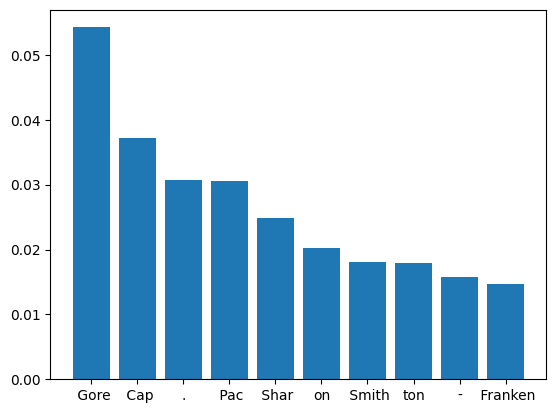

In [347]:
top_k_tokens, top_k_probabilities = get_top_k(input, model, tokenizer, sampling="top_k", k=10)

plt.bar(top_k_tokens, top_k_probabilities)

As we can see, our model believes the most likely token to follow Al is Gore, despite the context which suggests we are talking about Al Capone. While this error is in large part due to GPT-2s shortcomings, we do see that the second most likely token is ' Cap' the first of two tokens that make up 'Capone'. 

In the cell below we can see how this next token changes by using top_k sampling. Run multiple times to see it change. The default k value in my implementation is 10, so it will pick from one of the tokens we see in the plot above.

In [292]:
next_token_id, past_key_values = generate_token(input, model, sampling="top_k")
print(f'Generated Token Id: {next_token_id}')
next_token = tokenizer.decode(next_token_id)
print(f'{prompt}{next_token}')

Generated Token Id: tensor([4176])
He was the boss of Chicago in the 20s and his name was Al Smith


#### Top P Sampling

We can also experiment with top p sampling. Where we sample from the tokens whose cumulative probability adds up to p. We can adjust p below and see which tokens we get from the distribution plotted above. For example for p=0.2 we know that the first 4 or so tokens are chosen.

In [317]:
next_token_id, past_key_values = generate_token(input, model, sampling="top_p", p=0.2)
print(f'Generated Token Id: {next_token_id}')
next_token = tokenizer.decode(next_token_id)
print(f'{prompt}{next_token}')

Generated Token Id: tensor([15465])
He was the boss of Chicago in the 20s and his name was Al Shar


' put Pl'

#### Caching

In [308]:
next_token_id = generate_token(input, model, caching=False)
print(f'Generated Token Id: {next_token_id}')
next_token = tokenizer.decode(next_token_id)
print(f'{prompt}{next_token}')

Generated Token Id: tensor([17557])
He was the boss of Chicago in the 20s and his name was Al Gore


In [340]:
max_tokens = 50
t0 = time.time()
generated_tokens = generate_one_sequence(input, model, tokenizer, max_tokens, caching=False)
t1 = time.time() - t0
print(f'{prompt}{"".join(generated_tokens)}')
print(f'Generated {max_tokens} tokens in {t1}s')


He was the boss of Chicago in the 20s and his name was Al Gore. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the
Generated 50 tokens in 1.975188970565796s


In [341]:
t0 = time.time()
generated_tokens = generate_one_sequence(input, model, tokenizer, max_tokens)
t1 = time.time() - t0
print(f'{prompt}{"".join(generated_tokens)}')
print(f'Generated {max_tokens} tokens in {t1}s')

He was the boss of Chicago in the 20s and his name was Al Gore. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the
Generated 50 tokens in 1.0048449039459229s


In [342]:
t0 = time.time()
generated_tokens_top_k = generate_one_sequence(input, model, tokenizer, max_tokens, sampling="top_p", p=0.95)
t1 = time.time() - t0
print(f'{prompt}{"".join(generated_tokens)}')
print(f'Generated {max_tokens} tokens in {t1}s')

He was the boss of Chicago in the 20s and his name was Al Gore. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the
Generated 50 tokens in 1.216845989227295s


#### Temperature

In [350]:
from ipywidgets import interact

def show_plot(i, temperature):
    x, y = get_top_k(input, model, tokenizer, k=10, i=i, temperature=temperature, sampling="top_k")
    plt.bar(x, y)
    plt.xlabel('Top 10 Tokens')
    plt.ylabel('Probability')
    plt.title("Probability Distribution of Top 10 Tokens")
    plt.xticks(rotation=-45)
    plt.show()

# Create a slider
interact(show_plot, i=(0, len(generated_tokens) - 1), temperature = (1, 10))

interactive(children=(IntSlider(value=24, description='i', max=49), IntSlider(value=5, description='temperatur…

<function __main__.show_plot(i, temperature)>

For 50 tokens, generation without caching takes twice as long as generation with. The longer the output the more time caching saves us. 

In [344]:
prompts = ["He was the boss of Chicago in the 20s and his name was Al",
           "In Game of Thrones, Ned Stark had five children. From oldest to youngest, their names were ",
           'def generate_token(inputs, model, sampling="greedy"): ']

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

inputs = tokenizer(prompts, padding=True, return_tensors="pt")
inputs

{'input_ids': tensor([[50256, 50256, 50256, 50256, 50256,  1544,   373,   262,  6478,   286,
          4842,   287,   262,  1160,    82,   290,   465,  1438,   373,   978],
        [  818,  3776,   286, 20902,    11, 35754, 20956,   550,  1936,  1751,
            13,  3574, 13325,   284, 18887,    11,   511,  3891,   547,   220],
        [50256, 50256, 50256,  4299,  7716,    62, 30001,     7, 15414,    82,
            11,  2746,    11, 19232,  2625, 16694,  4716,     1,  2599,   220]]), 'attention_mask': tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [345]:
next_token_ids, past_key_values = generate_token(inputs, model)

print(next_token_ids.shape)
next_tokens = tokenizer.batch_decode(next_token_ids)
for i, prompt in enumerate(prompts):
    print(f'{prompt}{next_tokens[i]}')

torch.Size([3])
He was the boss of Chicago in the 20s and his name was Al in
In Game of Thrones, Ned Stark had five children. From oldest to youngest, their names were  
def generate_token(inputs, model, sampling="greedy"):  


In [346]:
generated_texts = generate(inputs, model, tokenizer, 100)

for prompt, generated in zip(prompts, generated_texts):
    print(prompt, f'"\x1b[31m{generated}\x1b[0m\n')

He was the boss of Chicago in the 20s and his name was Al " Gore. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States. He was the president of the United States

In Game of Thrones, Ned Stark had five children. From oldest to youngest, their names were  " Darth, Dany, Dany, and Dany.
Dany was the youngest, and Dany was the oldest.
Dany was the youngest, and Dany was the oldest.
Dany was the youngest, and Dany was the oldest.
Dany was the youngest, and Dany was the oldest.
Dany was the youngest, and Dany was the oldest.
Dany was the youngest, and Dany was the oldest.
D

def generate_token(inputs, model, sampling="gre